# Image Classification with CNN using Keras

# Task 1: Import Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np
import tensorflow.keras.datasets

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.0.0
Is using GPU? False


# Task 2: Preprocess Data

In [2]:
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]    
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

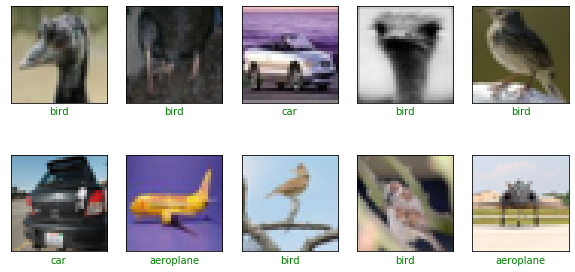

In [4]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)  #replace means that all items returned will be unique
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range (10):
        plt.subplot(2, 5, 1+i)  #2 rows and 5 columns and index starting with 1of the subplot
        plt.imshow(x[i])
        plt.xticks([])    #xticks and yticks is used to make the representation clean
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red' #colors given to easily identify wrong prediction if any
        plt.xlabel(class_names[np.argmax(p[i])], color=col) #np.argmax() function returns the indices of maximum elements along the specific axis inside the array.
    plt.show()
show_random_examples(x_train, y_train, y_train)


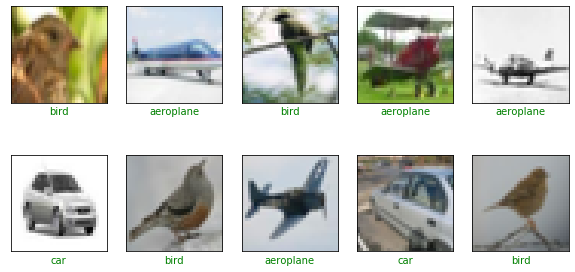

In [5]:
show_random_examples(x_test, y_test, y_test)

# Task 4: Create Model

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu')) #3 is the kernel size
        model.add(MaxPooling2D(pool_size=2)) #reduce the rows and colums to half of the original value
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3))) #specify the input shape as seen in task 2
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam', metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

# Task 5: Train the Model

In [8]:
h = model.fit(
    x_train/255., y_train, #division of 255 is done to achieve normalization of all items in x_train
    validation_data = (x_test/255., y_test),
    epochs = 10, batch_size = 128,
    callbacks = [                          
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3), #earlystopping is done to avoid overfitting..overfitting is merging of the classes in the curve(see graph of overfitting in google)
        tf.keras.callbacks.ModelCheckpoint(                #patience is no. of epochs with no improvement after which training will be stopped
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only=True, save_weights_only=False,
            monitor='val_accuracy'
        )
    ]
)

Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 186s 12ms/sample - loss: 0.9205 - accuracy: 0.6767 - val_loss: 2.6684 - val_accuracy: 0.3573
Epoch 2/10
15000/15000 [==============================] - 164s 11ms/sample - loss: 0.5505 - accuracy: 0.7801 - val_loss: 2.1939 - val_accuracy: 0.3560
Epoch 3/10
15000/15000 [==============================] - 160s 11ms/sample - loss: 0.4814 - accuracy: 0.8051 - val_loss: 2.1689 - val_accuracy: 0.3813
Epoch 4/10
15000/15000 [==============================] - 161s 11ms/sample - loss: 0.4432 - accuracy: 0.8235 - val_loss: 1.4215 - val_accuracy: 0.5490
Epoch 5/10
15000/15000 [==============================] - 160s 11ms/sample - loss: 0.4024 - accuracy: 0.8441 - val_loss: 0.7435 - val_accuracy: 0.7107
Epoch 6/10
15000/15000 [==============================] - 160s 11ms/sample - loss: 0.3798 - accuracy: 0.8501 - val_loss: 0.5965 - val_accuracy: 0.8020
Epoch 7/10
15000/15000 [=====================

# Task 6: Final Predictions

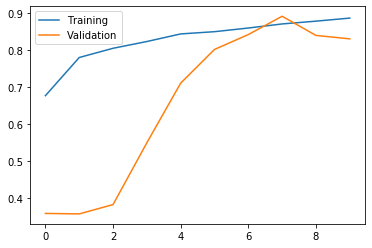

In [9]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')
plt.legend()
plt.show()   #this graph is seen to ananlyse -- if any significant overfitting has taken place or not

In [10]:
#you can either use the existing model or the best_fit model obtained during training
#here we have chosen the model which had 89% accuracy, it may vary for everyone although it may be close towards 90%
model = tf.keras.models.load_model('models/model_0.892.h5')

In [11]:
preds = model.predict(x_test/255.)

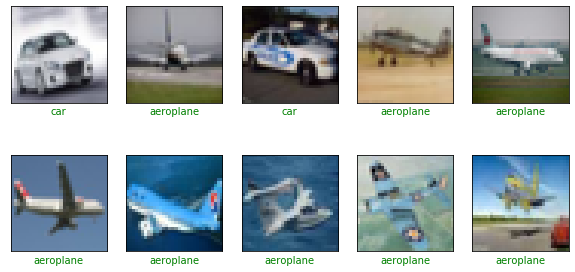

In [12]:
show_random_examples(x_test, y_test, preds)